Approach 3– Multivariate Combined

Input features: Open, High, Low, Close, Volume

Target variable: Close

Lookback window: 90

Layers: 3

Units: 128

Dropout: 0.3

Optimizer: Adam (learning rate = 0.0005 with gradient clipping)

Loss: MSE

Batch size: 16

Epochs: up to 200

In [ ]:
import os, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Model
from IPython.display import display

np.random.seed(42)
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

TensorFlow: 2.19.0


In [ ]:
# ====================== Config (Multivariate GRU) ======================
CSV_PATH    = "../dataset/TSLA.csv"   # change if needed
DATE_COL    = "Date"
CLOSE_COL   = "Close"
TRAIN_START = "2015-01-12"

# Features for multivariate input
FEATURE_COLS = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
CLOSE_IDX    = FEATURE_COLS.index(CLOSE_COL)  # index of Close in the feature vector

LOOKBACK    = 90
EPOCHS      = 200
BATCH_SIZE  = 16

# LSTM+GRU core
LSTM_UNITS    = 128
GRU_UNITS     = 128
LSTM_DROPOUT  = 0.3
GRU_DROPOUT   = 0.3
LSTM_LAYERS  = 3
GRU_LAYERS   = 3

TRAIN_RATIO = 0.80
VAL_RATIO   = 0.10
TEST_RATIO  = 0.10

In [ ]:
CSV_PATH = "/content/TSLA.csv" # Update this path after uploading the file
import os
print(os.path.exists(CSV_PATH))

True


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-12,13.536667,13.631333,13.283333,13.480667,13.480667,89254500
2015-01-13,13.554667,13.840667,13.394000,13.616667,13.616667,67159500
2015-01-14,12.388667,13.013333,12.333333,12.846000,12.846000,173278500


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-11,173.919998,174.750000,167.410004,170.660004,170.660004,64761900
2024-06-12,171.119995,180.550003,169.800003,177.289993,177.289993,89884800
2024-06-13,188.427994,191.050003,181.940094,184.434998,184.434998,97297153


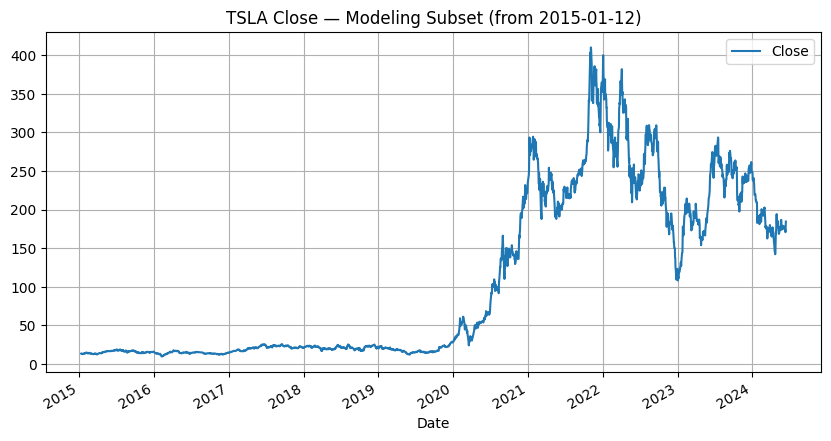

In [ ]:
# ====================== Load, clean, plot ======================
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Update CSV_PATH.")

df = pd.read_csv(CSV_PATH)
if DATE_COL not in df.columns or CLOSE_COL not in df.columns:
    raise ValueError(
        f"Expected '{DATE_COL}' and '{CLOSE_COL}' in columns: {df.columns.tolist()}"
    )

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True).set_index(DATE_COL)

df = df[df.index >= TRAIN_START].copy()

# Handle missing values in all feature columns
if df[FEATURE_COLS].isna().any().any():
    df[FEATURE_COLS] = (
        df[FEATURE_COLS]
        .interpolate(method="time")
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

display(df[FEATURE_COLS].head(3))
display(df[FEATURE_COLS].tail(3))

df[[CLOSE_COL]].plot(title=f"TSLA Close — Modeling Subset (from {TRAIN_START})")
plt.show()

In [ ]:
# ====================== Chronological 80/10/10 split (no leakage) ======================
feature_values = df[FEATURE_COLS].values.astype("float32")  # (N, D)
n = len(feature_values)
n_train = int(np.floor(TRAIN_RATIO * n))
n_val   = int(np.floor(VAL_RATIO   * n))
n_test  = n - n_train - n_val

assert n_train > LOOKBACK and n_val > 0 and n_test > 0, \
    "Not enough data for chosen LOOKBACK/splits."

train_raw = feature_values[:n_train]
val_raw   = feature_values[n_train:n_train+n_val]
test_raw  = feature_values[n_train+n_val:]

# Scale ALL features together
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_raw)   # fit on TRAIN only

train_scaled = scaler.transform(train_raw)
val_scaled   = scaler.transform(val_raw)
test_scaled  = scaler.transform(test_raw)

print(f"Total: {n} | Train: {n_train} | Val: {n_val} | Test: {n_test}")

Total: 2372 | Train: 1897 | Val: 237 | Test: 238


In [ ]:
# ====================== Windowing util (multivariate) ======================
def make_xy(series_2d, lookback=60, target_idx=0):
    """
    series_2d: shape (N, F).
    Returns:
      X: (samples, lookback, F)
      y: (samples,)  -- target feature at each step
    """
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i - lookback:i, :])
        y.append(series_2d[i, target_idx])  # target is Close (scaled)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

# Train windows come purely from train
X_train, y_train = make_xy(train_scaled, LOOKBACK, CLOSE_IDX)

# Validation windows need LOOKBACK context from the end of train
val_with_ctx = np.concatenate([train_scaled[-LOOKBACK:], val_scaled], axis=0)
X_val, y_val = make_xy(val_with_ctx, LOOKBACK, CLOSE_IDX)

# Test windows need LOOKBACK context from the end of val
test_with_ctx = np.concatenate([val_scaled[-LOOKBACK:], test_scaled], axis=0)
X_test, y_test = make_xy(test_with_ctx, LOOKBACK, CLOSE_IDX)

print("Shapes:",
      "\n  X_train", X_train.shape, "y_train", y_train.shape,
      "\n  X_val  ", X_val.shape,   "y_val  ", y_val.shape,
      "\n  X_test ", X_test.shape,  "y_test ", y_test.shape)


Shapes: 
  X_train (1807, 90, 6) y_train (1807,) 
  X_val   (237, 90, 6) y_val   (237,) 
  X_test  (238, 90, 6) y_test  (238,)


In [ ]:
# ====================== LSTM+GRU combined model ======================
def build_lstm_gru(lookback=90,
                   lstm_units=128,
                   gru_units=128,
                   lstm_layers=3,
                   gru_layers=3,
                   dropout=0.3,
                   n_features=None):
    """
    Hybrid stacked LSTM+GRU regressor (multivariate input):
      Input:  (lookback, n_features)
      Architecture:
        LSTM (return_sequences=True)
        Dropout
        GRU  (return_sequences=False)
        Dropout
        Dense(1)
    """
    if n_features is None:
        raise ValueError("n_features must be provided for multivariate input.")

    inp = layers.Input(shape=(lookback, n_features))
    x = inp

    # LSTM layer outputs full sequence
    x = layers.LSTM(lstm_units, return_sequences=True)(x)
    x = layers.Dropout(dropout)(x)

    # GRU layer summarizes sequence into last hidden state
    x = layers.GRU(gru_units, return_sequences=False)(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model



In [ ]:
# ====================== Timing & per-epoch Test evaluation ======================
class TimeAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test, self.y_test = X_test, y_test
        self.cum_times = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        self._t0 = None

    def on_train_begin(self, logs=None):
        self._t0 = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        t_now = time.perf_counter()
        self.cum_times.append(t_now - self._t0)
        self.train_losses.append(float(logs.get("loss", np.nan)))
        self.val_losses.append(float(logs.get("val_loss", np.nan)))
        test_loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        self.test_losses.append(float(test_loss))

    def to_frame(self):
        df_log = pd.DataFrame({
            "epoch": np.arange(1, len(self.cum_times) + 1),
            "time_sec_cum": self.cum_times,
            "train_loss": self.train_losses,
            "val_loss": self.val_losses,
            "test_loss": self.test_losses
        })
        df_log["train_rmse"] = np.sqrt(df_log["train_loss"])
        df_log["test_rmse"]  = np.sqrt(df_log["test_loss"])
        return df_log


def timed_fit(model, X_train, y_train, X_val, y_val, X_test, y_test,
              epochs=EPOCHS, batch_size=BATCH_SIZE):
    tcb = TimeAndTestCallback(X_test, y_test)
    es  = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        verbose=1, shuffle=False,
        callbacks=[tcb, es]
        )
    return hist, tcb.to_frame()


In [ ]:
# ====================== Train LSTM+GRU ONCE (timed) ======================
n_features = X_train.shape[2]

lstm_gru_model = build_lstm_gru(
    lookback=LOOKBACK,
    lstm_units=LSTM_UNITS,
    gru_units=GRU_UNITS,
    dropout=LSTM_DROPOUT,
    n_features=n_features
)
print(lstm_gru_model.summary())

_, log_df_hybrid = timed_fit(
    lstm_gru_model, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS, batch_size=BATCH_SIZE
)

display(log_df_hybrid.head())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 90, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,321 (657.50 KB)

 Trainable params: 168,321 (657.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - loss: 6.4657e-04 - val_loss: 0.0057
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 0.0085 - val_loss: 0.0185
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - loss: 0.0123 - val_loss: 0.0112
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - loss: 0.0113 - val_loss: 0.0076
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 9/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 10/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - loss: 7.9367e-04 - val_loss: 0.0030
Epoch 11/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 5.8655e-04 - val_loss

,epoch,time_sec_cum,train_loss,val_loss,test_loss,train_rmse,test_rmse
0,1,19.233928,0.003128,0.005696,0.003454,0.055929,0.058770
1,2,38.770876,0.004925,0.018487,0.012539,0.070179,0.111976
2,3,53.453873,0.006715,0.011156,0.006688,0.081944,0.081782
3,4,74.018401,0.007681,0.007637,0.005578,0.087640,0.074688
4,5,89.757814,0.007697,0.003835,0.001520,0.087730,0.038986


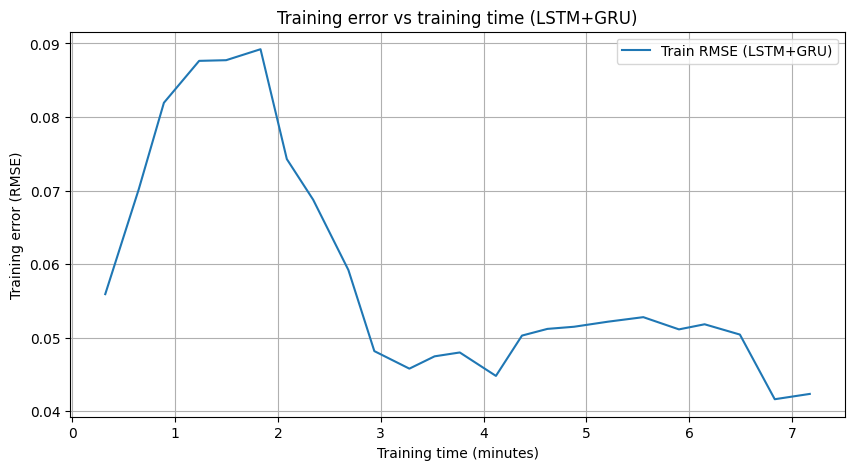

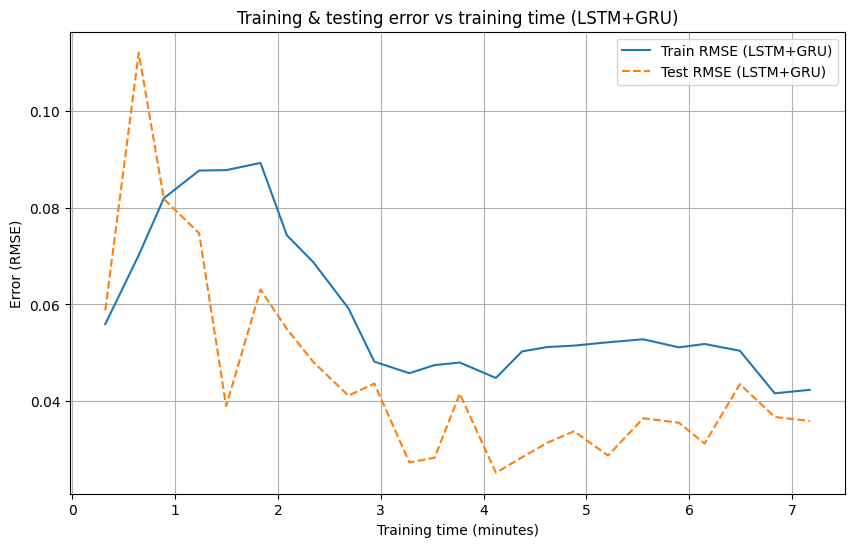

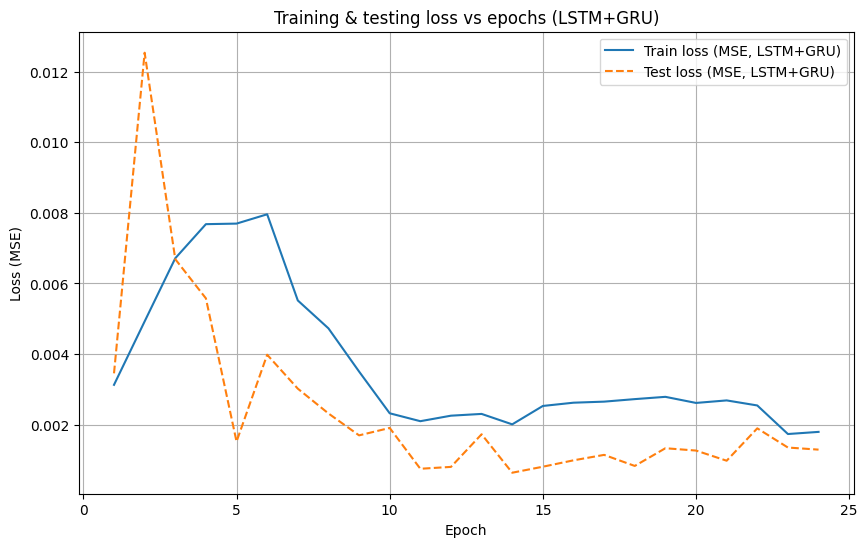

In [ ]:
# ====================== Required Plots (LSTM+GRU) ======================
# 1) Training error vs training time
plt.figure(figsize=(10,5))
plt.plot(log_df_hybrid["time_sec_cum"]/60.0, log_df_hybrid["train_rmse"], label="Train RMSE (LSTM+GRU)")
plt.xlabel("Training time (minutes)")
plt.ylabel("Training error (RMSE)")
plt.title("Training error vs training time (LSTM+GRU)")
plt.legend()
plt.grid(True)
plt.show()

# 2) Training & testing error vs training time
plt.figure(figsize=(10,6))
plt.plot(log_df_hybrid["time_sec_cum"]/60.0, log_df_hybrid["train_rmse"], label="Train RMSE (LSTM+GRU)")
plt.plot(log_df_hybrid["time_sec_cum"]/60.0, log_df_hybrid["test_rmse"],  linestyle="--", label="Test RMSE (LSTM+GRU)")
plt.xlabel("Training time (minutes)")
plt.ylabel("Error (RMSE)")
plt.title("Training & testing error vs training time (LSTM+GRU)")
plt.legend()
plt.grid(True)
plt.show()

# 3) Loss (training & testing) vs epochs
plt.figure(figsize=(10,6))
plt.plot(log_df_hybrid["epoch"], log_df_hybrid["train_loss"], label="Train loss (MSE, LSTM+GRU)")
plt.plot(log_df_hybrid["epoch"], log_df_hybrid["test_loss"],  linestyle="--", label="Test loss (MSE, LSTM+GRU)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & testing loss vs epochs (LSTM+GRU)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ====================== Metrics helpers ======================
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def collect_metrics(name, y_true, y_pred):
    return {
        "Model": name,
        "RMSE": rmse(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2":  r2_score(y_true, y_pred),
    }


def inverse_target_from_scaled(scaled_target_vec):
    """
    scaled_target_vec: array of shape (N,) in scaled space for the target feature only.
    Uses the multivariate scaler to inverse just the target (Close) dimension.
    """
    dummy = np.zeros((len(scaled_target_vec), len(FEATURE_COLS)), dtype=np.float32)
    dummy[:, CLOSE_IDX] = scaled_target_vec
    inv_full = scaler.inverse_transform(dummy)
    return inv_full[:, CLOSE_IDX]


In [ ]:
# ====================== TEST endpoint predictions & metrics for H in {1,7,15} ======================
def endpoint_results_for_H(model, H, use_val_context=True, model_name_prefix="LSTM+GRU"):
    """
    Build Actual vs Predicted (endpoint-only) for TEST at horizon H (multivariate input).
    use_val_context=True -> test windows may use LOOKBACK context from validation.
    """
    scaled_full = scaler.transform(df[FEATURE_COLS].values.astype("float32"))
    start_test = n_train + n_val
    n_total = len(scaled_full)

    if use_val_context:
        start_t = max(start_test, LOOKBACK)
    else:
        start_t = max(start_test + LOOKBACK, LOOKBACK)

    end_t = n_total - H

    dates, true_end_scaled, pred_end_scaled = [], [], []

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t, :]   # (lookback, F)
        w = window.reshape(1, LOOKBACK, n_features).copy()

        p = None
        for _ in range(H):
            p = model.predict(w, verbose=0)[0, 0]  # scalar (scaled Close)

            # build next feature vector: copy last row, replace Close with p
            last_vec = w[:, -1, :].copy()          # (1, F)
            last_vec[0, CLOSE_IDX] = p
            new_point = last_vec.reshape(1, 1, n_features)

            w = np.concatenate([w[:, 1:, :], new_point], axis=1)

        pred_end_scaled.append(p)
        true_end_scaled.append(scaled_full[t + H - 1, CLOSE_IDX])
        dates.append(df.index[t + H - 1])

    inv_true = inverse_target_from_scaled(np.array(true_end_scaled))
    inv_pred = inverse_target_from_scaled(np.array(pred_end_scaled))

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )

    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Test metrics (H={H}): {m}")
    return results, m


# Run for H = 1, 7, 15 on TEST
results_1_h,  metrics_1_h  = endpoint_results_for_H(lstm_gru_model, H=1,  use_val_context=True, model_name_prefix="LSTM+GRU")
display(results_1_h.head())

results_7_h,  metrics_7_h  = endpoint_results_for_H(lstm_gru_model, H=7,  use_val_context=True, model_name_prefix="LSTM+GRU")
display(results_7_h.head())

results_15_h, metrics_15_h = endpoint_results_for_H(lstm_gru_model, H=15, use_val_context=True, model_name_prefix="LSTM+GRU")
display(results_15_h.head())

summary_test_h = pd.DataFrame(
    [metrics_1_h, metrics_7_h, metrics_15_h]
)[["Model","RMSE","MSE","MAE","R2"]]

display(
    summary_test_h
        .style.format({"RMSE":"{:.4f}","MSE":"{:.4f}","MAE":"{:.4f}","R2":"{:.4f}"})
        .set_caption("TEST metrics by horizon (LSTM+GRU, multivariate)")
)


Test metrics (H=1): {'Model': 'LSTM+GRU(H=1)', 'RMSE': 10.129450443947427, 'MSE': 102.60576629638672, 'MAE': 8.202190399169922, 'R2': 0.924691915512085}


,Actual,LSTM+GRU(H=1)
Date,,
2023-07-06,276.540009,266.352600
2023-07-07,274.429993,267.800323
2023-07-10,269.609985,267.687653
2023-07-11,269.790009,265.684662
2023-07-12,271.989990,263.023590


Test metrics (H=7): {'Model': 'LSTM+GRU(H=7)', 'RMSE': 17.51013151893917, 'MSE': 306.6047058105469, 'MAE': 14.069648742675781, 'R2': 0.7665446996688843}


,Actual,LSTM+GRU(H=7)
Date,,
2023-07-14,281.380005,268.108368
2023-07-17,290.380005,264.513245
2023-07-18,293.339996,263.950256
2023-07-19,291.260010,260.547516
2023-07-20,262.899994,256.987366


Test metrics (H=15): {'Model': 'LSTM+GRU(H=15)', 'RMSE': 22.97315141714685, 'MSE': 527.7656860351562, 'MAE': 18.607728958129883, 'R2': 0.5659807920455933}


,Actual,LSTM+GRU(H=15)
Date,,
2023-07-26,264.350006,267.578491
2023-07-27,255.710007,264.075470
2023-07-28,266.440002,263.616333
2023-07-31,267.429993,260.489441
2023-08-01,261.070007,256.741364


,Model,RMSE,MSE,MAE,R2
0,LSTM+GRU(H=1),10.1295,102.6058,8.2022,0.9247
1,LSTM+GRU(H=7),17.5101,306.6047,14.0696,0.7665
2,LSTM+GRU(H=15),22.9732,527.7657,18.6077,0.5660


In [ ]:
# ====================== TRAIN endpoint metrics for H in {1,7,15} ======================
def endpoint_train_results_for_H(model, H, model_name_prefix="LSTM+GRU"):
    """
    Build Actual vs Predicted (endpoint-only) for TRAIN at horizon H (multivariate input).
    Uses only the train region [0, n_train).
    """
    scaled_full = scaler.transform(df[FEATURE_COLS].values.astype("float32"))

    start_t = LOOKBACK
    end_t   = n_train - H

    dates, true_end_scaled, pred_end_scaled = [], [], []

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t, :]
        w = window.reshape(1, LOOKBACK, n_features).copy()

        p = None
        for _ in range(H):
            p = model.predict(w, verbose=0)[0, 0]
            last_vec = w[:, -1, :].copy()
            last_vec[0, CLOSE_IDX] = p
            new_point = last_vec.reshape(1, 1, n_features)

            w = np.concatenate([w[:, 1:, :], new_point], axis=1)

        pred_end_scaled.append(p)
        true_end_scaled.append(scaled_full[t + H - 1, CLOSE_IDX])
        dates.append(df.index[t + H - 1])

    inv_true = inverse_target_from_scaled(np.array(true_end_scaled))
    inv_pred = inverse_target_from_scaled(np.array(pred_end_scaled))

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )

    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Train metrics (H={H}): {m}")
    return results, m


# TRAIN metrics by horizon
train_res_1_h,  train_metrics_1_h  = endpoint_train_results_for_H(lstm_gru_model, H=1,  model_name_prefix="LSTM+GRU")
train_res_7_h,  train_metrics_7_h  = endpoint_train_results_for_H(lstm_gru_model, H=7,  model_name_prefix="LSTM+GRU")
train_res_15_h, train_metrics_15_h = endpoint_train_results_for_H(lstm_gru_model, H=15, model_name_prefix="LSTM+GRU")

summary_train_h = pd.DataFrame(
    [train_metrics_1_h, train_metrics_7_h, train_metrics_15_h]
)[["Model", "RMSE", "MSE", "MAE", "R2"]]

display(
    summary_train_h
        .style.format({"RMSE": "{:.4f}", "MSE": "{:.4f}", "MAE": "{:.4f}", "R2": "{:.4f}"})
        .set_caption("TRAIN metrics by horizon (LSTM+GRU, multivariate)")
)


Train metrics (H=1): {'Model': 'LSTM+GRU(H=1)', 'RMSE': 16.128749677582245, 'MSE': 260.1365661621094, 'MAE': 12.725714683532715, 'R2': 0.9770019054412842}
Train metrics (H=7): {'Model': 'LSTM+GRU(H=7)', 'RMSE': 22.57642254070224, 'MSE': 509.6948547363281, 'MAE': 17.23581314086914, 'R2': 0.9550291299819946}
Train metrics (H=15): {'Model': 'LSTM+GRU(H=15)', 'RMSE': 25.381790530365343, 'MSE': 644.2352905273438, 'MAE': 18.304187774658203, 'R2': 0.9433103799819946}


,Model,RMSE,MSE,MAE,R2
0,LSTM+GRU(H=1),16.1287,260.1366,12.7257,0.9770
1,LSTM+GRU(H=7),22.5764,509.6949,17.2358,0.9550
2,LSTM+GRU(H=15),25.3818,644.2353,18.3042,0.9433
